# Postprocessing

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from parameters import N, beta, sigma, S0, I0, R0

sns.set_theme(style="whitegrid")
plt.rcParams['figure.constrained_layout.use'] = True

## Multiple Layers

In [2]:
data_path = Path().resolve().parent / "output"
y0 = [S0, I0, R0]

parameters_real = {"beta": beta, "sigma": sigma}

In [3]:
def read_pred_history(filepath):
    lines = open(filepath, "r").readlines()
    raw_parameters_pred_history = np.array(
        [
            np.fromstring(
                min(re.findall(re.escape("[") + "(.*?)" + re.escape("]"), line), key=len),
                sep=",",
            )
            for line in lines
        ]
    )

    iterations = [int(re.findall("^[0-9]+", line)[0]) for line in lines]
    parameters_pred_history = {
        name: raw_parameters_pred_history[:, i]
        for i, (name, _) in enumerate(parameters_real.items())
    }
    return iterations, parameters_pred_history


def error_analysis(data_path, prefix):
    error_dict = {}
    for f in data_path.glob(f"{prefix}*_relative_error.csv"):
        if not re.search(rf"{prefix}(\d*?)_relative_error", f.stem):
            continue
        experiment_id = f.stem.removeprefix(prefix).removesuffix("_relative_error")
        error_dict[experiment_id] = pd.read_csv(f, index_col=0)
    error_df = pd.concat(error_dict).rename_axis(["experiment_id", "parameter"]).reset_index()

    pred_history_dict = {}
    for f in data_path.glob(f"*.dat"):
        if not re.search(rf"{prefix}(\d*?)$", f.stem):
            continue
        name = f.stem.removeprefix(prefix)
        iterations, pred_history = read_pred_history(f)
        pred_history_dict[name] = pd.DataFrame(pred_history, index=iterations)
    pred_history_df = (
        pd.concat(pred_history_dict)
        .rename_axis(["experiment_id", "Iteration"])
        .reset_index()
        .melt(
            id_vars=["experiment_id", "Iteration"],
            value_vars=["beta", "sigma"],
            var_name="Parameter",
            value_name="Estimation"
        )
    )
    return error_df, pred_history_df

In [4]:
error_df, pred_history_df = error_analysis(data_path, prefix="sir_")

/tmp/ipykernel_1495/500826118.py:5: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/tmp/ipykernel_1495/500826118.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([r"$\beta$", r"$\sigma$"])
/tmp/ipykernel_1495/500826118.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([r"$\beta$", r"$\sigma$"])


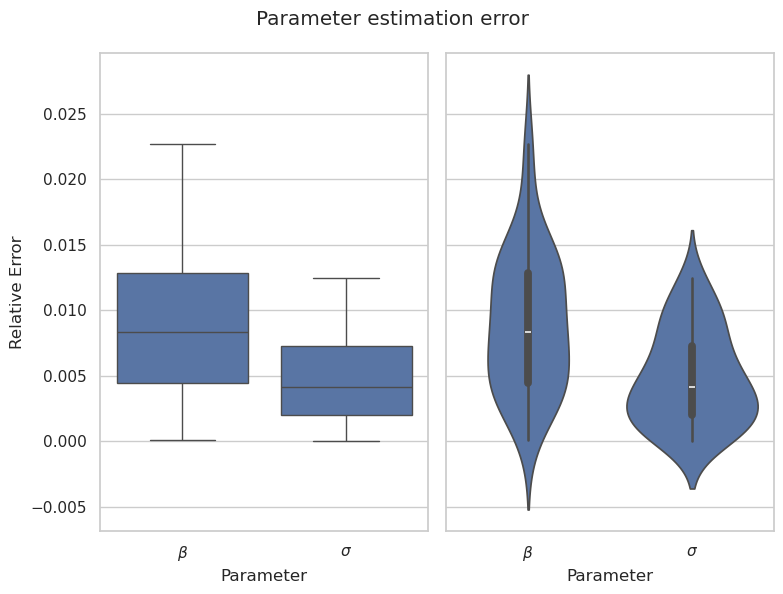

In [5]:
fig, axs = plt.subplots(ncols=2, figsize=(8, 6), sharey=True)
sns.boxplot(data=error_df, y="Relative Error", x="parameter", ax=axs[0])
sns.violinplot(data=error_df, y="Relative Error", x="parameter", ax=axs[1])
fig.suptitle(r"Parameter estimation error")
fig.tight_layout()
for ax in axs.flatten():
    ax.set_xticklabels([r"$\beta$", r"$\sigma$"])
    ax.set_xlabel("Parameter")
fig.savefig(data_path / "parameter_estimaton_boxplot_violin.png", dpi=300)

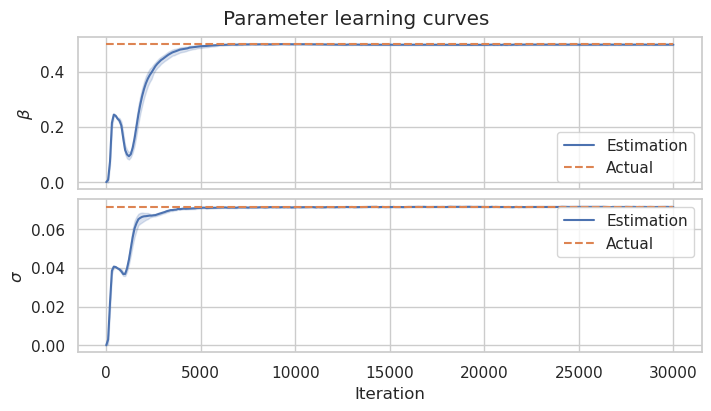

In [6]:
parameter_latex = {"beta": r"$\beta$", "sigma": r"$\sigma$"}
fig, axs = plt.subplots(nrows=2, figsize=(7, 4), sharex=True)
for ax, (param_name, param_value) in zip(axs.flatten(), parameters_real.items()):
    sns.lineplot(
        data=pred_history_df.query(f"Parameter == @param_name"),
        x="Iteration",
        y="Estimation",
        label="Estimation",
        ax=ax
    )
    ax.hlines(param_value, xmin=0, xmax=pred_history_df["Iteration"].max(), linestyles="dashed", color=sns.color_palette()[1], label="Actual")
    ax.legend()
    ax.set_ylabel(parameter_latex[param_name])
fig.suptitle(r"Parameter learning curves")
fig.savefig(data_path / "parameter_estimation_learning_curves.png", dpi=300)

In [9]:
error_df.groupby("parameter").agg(prediction_mean=("Predicted", "mean"), prediction_std=("Predicted", "std"))

,prediction_mean,prediction_std
parameter,,
beta,0.497140,0.004446
sigma,0.071322,0.000420


## Single layer

In [ ]:
def error_analysis_neurons(data_path, prefix, n_neurons):
    error_dict = {}
    for f in data_path.glob(f"{prefix}*_{n_neurons}_neurons_relative_error.csv"):
        if not re.search(rf"{prefix}(\d*?)_{n_neurons}_neurons_relative_error", f.stem):
            continue
        experiment_id = f.stem.removeprefix(prefix).removesuffix(f"_{n_neurons}_neurons_relative_error")
        error_dict[experiment_id] = pd.read_csv(f, index_col=0)
    error_df = pd.concat(error_dict).rename_axis(["experiment_id", "parameter"]).reset_index()

    pred_history_dict = {}
    for f in data_path.glob(f"*.dat"):
        if not re.search(rf"{prefix}(\d*?)_{n_neurons}_neurons$", f.stem):
            continue
        name = f.stem.removeprefix(prefix).removesuffix(f"_{n_neurons}_neurons")
        iterations, pred_history = read_pred_history(f)
        pred_history_dict[name] = pd.DataFrame(pred_history, index=iterations)
    pred_history_df = (
        pd.concat(pred_history_dict)
        .rename_axis(["experiment_id", "Iteration"])
        .reset_index()
        .melt(
            id_vars=["experiment_id", "Iteration"],
            value_vars=["beta", "sigma"],
            var_name="Parameter",
            value_name="Estimation"
        )
    )
    return error_df, pred_history_df

In [ ]:
error_dict = {}
pred_history_dict = {}
for n_neurons in range(1, 5 + 1):
    error_df, pred_history_df = error_analysis_neurons(data_path, prefix="sir_", n_neurons=n_neurons)
    error_dict[n_neurons] = error_df
    pred_history_dict[n_neurons] = pred_history_df

error_neurons_df = pd.concat(error_dict).rename_axis(["n_neurons", ""]).droplevel(1).reset_index()
pred_history_neurons_df = pd.concat(pred_history_dict).rename_axis(["n_neurons", ""]).droplevel(1).reset_index()

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(8, 6), sharey=True)
sns.boxplot(data=error_neurons_df, y="Relative Error", x="parameter", hue="n_neurons", ax=axs[0])
sns.violinplot(data=error_neurons_df, y="Relative Error", x="parameter", hue="n_neurons", ax=axs[1])
fig.suptitle(r"Parameter estimation error")
fig.tight_layout()
for ax in axs.flatten():
    ax.set_xticklabels([r"$\beta$", r"$\sigma$"])
    ax.set_xlabel("Parameter")
# fig.savefig(data_path / "parameter_estimaton_boxplot_violin_single_layer.png", dpi=300)

In [ ]:
parameter_latex = {"beta": r"$\beta$", "sigma": r"$\sigma$"}
fig, axs = plt.subplots(nrows=2, figsize=(7, 4), sharex=True)
for ax, (param_name, param_value) in zip(axs.flatten(), parameters_real.items()):
    sns.lineplot(
        data=pred_history_neurons_df.query(f"Parameter == @param_name"),
        x="Iteration",
        y="Estimation",
        hue="n_neurons",
        # label="Estimation",
        ax=ax
    )
    ax.hlines(param_value, xmin=0, xmax=pred_history_df["Iteration"].max(), linestyles="dashed", color=sns.color_palette()[1], label="Actual")
    # ax.legend()
    ax.set_ylabel(parameter_latex[param_name])
fig.suptitle(r"Parameter learning curves")
# fig.savefig(data_path / "parameter_estimation_learning_curves_single_layer.png", dpi=300)

## Different layers but 5 neurons

In [10]:
def error_analysis_layers(data_path, prefix, n_layers):
    error_dict = {}
    for f in data_path.glob(f"{prefix}*_{n_layers}_layers_relative_error.csv"):
        if not re.search(rf"{prefix}(\d*?)_{n_layers}_layers_relative_error", f.stem):
            continue
        experiment_id = f.stem.removeprefix(prefix).removesuffix(f"_{n_layers}_layers_relative_error")
        error_dict[experiment_id] = pd.read_csv(f, index_col=0)
    error_df = pd.concat(error_dict).rename_axis(["experiment_id", "parameter"]).reset_index()

    pred_history_dict = {}
    for f in data_path.glob(f"*.dat"):
        if not re.search(rf"{prefix}(\d*?)_{n_layers}_layers$", f.stem):
            continue
        name = f.stem.removeprefix(prefix).removesuffix(f"_{n_layers}_layers")
        iterations, pred_history = read_pred_history(f)
        pred_history_dict[name] = pd.DataFrame(pred_history, index=iterations)
    pred_history_df = (
        pd.concat(pred_history_dict)
        .rename_axis(["experiment_id", "Iteration"])
        .reset_index()
        .melt(
            id_vars=["experiment_id", "Iteration"],
            value_vars=["beta", "sigma"],
            var_name="Parameter",
            value_name="Estimation"
        )
    )
    return error_df, pred_history_df

In [11]:
error_dict = {}
pred_history_dict = {}
for n_layers in range(1, 3 + 1):
    error_df, pred_history_df = error_analysis_layers(data_path, prefix="sir_", n_layers=n_layers)
    error_dict[n_layers] = error_df
    pred_history_dict[n_layers] = pred_history_df

error_layers_df = pd.concat(error_dict).rename_axis(["n_layers", ""]).droplevel(1).reset_index()
pred_history_layers_df = pd.concat(pred_history_dict).rename_axis(["n_layers", ""]).droplevel(1).reset_index()

/tmp/ipykernel_1495/566602714.py:5: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/tmp/ipykernel_1495/566602714.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([r"$\beta$", r"$\sigma$"])
/tmp/ipykernel_1495/566602714.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([r"$\beta$", r"$\sigma$"])


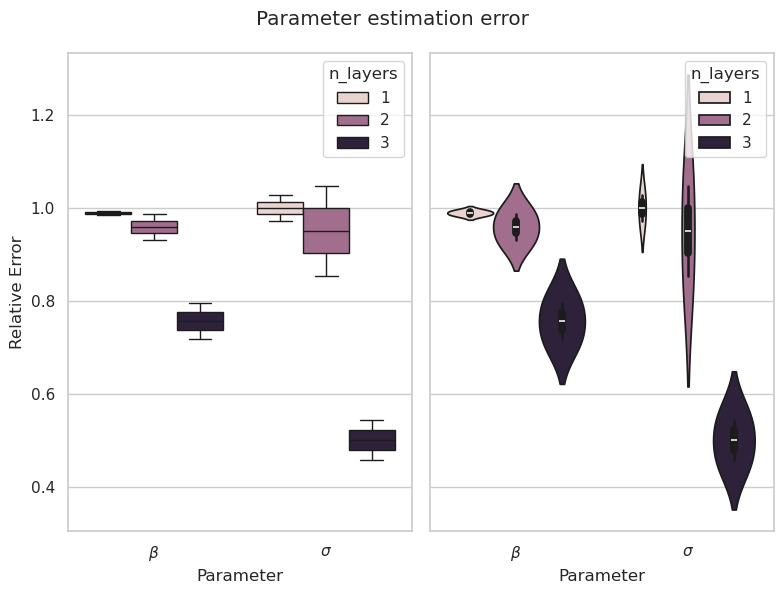

In [13]:
fig, axs = plt.subplots(ncols=2, figsize=(8, 6), sharey=True)
sns.boxplot(data=error_layers_df, y="Relative Error", x="parameter", hue="n_layers", ax=axs[0])
sns.violinplot(data=error_layers_df, y="Relative Error", x="parameter", hue="n_layers", ax=axs[1])
fig.suptitle(r"Parameter estimation error")
fig.tight_layout()
for ax in axs.flatten():
    ax.set_xticklabels([r"$\beta$", r"$\sigma$"])
    ax.set_xlabel("Parameter")
# fig.savefig(data_path / "parameter_estimaton_boxplot_violin_single_layer.png", dpi=300)

Text(0.5, 0.98, 'Parameter learning curves')

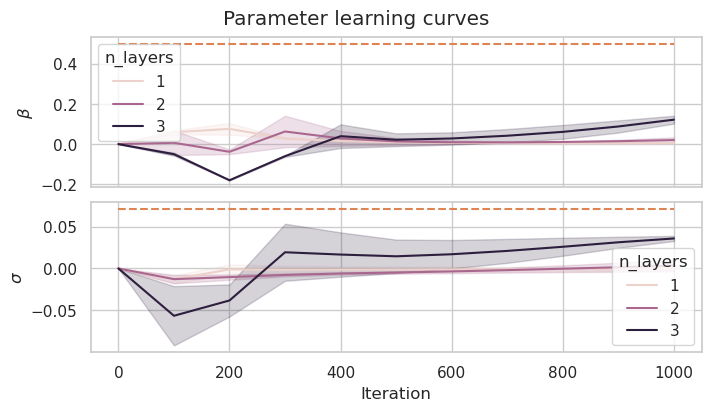

In [14]:
parameter_latex = {"beta": r"$\beta$", "sigma": r"$\sigma$"}
fig, axs = plt.subplots(nrows=2, figsize=(7, 4), sharex=True)
for ax, (param_name, param_value) in zip(axs.flatten(), parameters_real.items()):
    sns.lineplot(
        data=pred_history_layers_df.query(f"Parameter == @param_name"),
        x="Iteration",
        y="Estimation",
        hue="n_layers",
        # label="Estimation",
        ax=ax
    )
    ax.hlines(param_value, xmin=0, xmax=pred_history_df["Iteration"].max(), linestyles="dashed", color=sns.color_palette()[1], label="Actual")
    # ax.legend()
    ax.set_ylabel(parameter_latex[param_name])
fig.suptitle(r"Parameter learning curves")
# fig.savefig(data_path / "parameter_estimation_learning_curves_single_layer.png", dpi=300)